# Generating plots for mass and $t_c$ posteriors

In [1]:
import configparser
import corner
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from scipy import stats

from plotting_utils import (
    generate_all_params,
    psd_colours,
    psd_labels,
    psd_markers,
    psd_ls,
    times_lookup,
    get_times_array,
    get_priors,
)

plt.style.use("../paper.mplstyle")

In [2]:
colours = {f"time {i}": c for i, c in enumerate(sns.color_palette("viridis", n_colors=5), start=1)}

In [3]:
psds = ["optimistic", "pessimistic", "cut"]

In [4]:
posterior_samples = {}
for inj in range(5):
    posterior_samples[inj] = {}
    with h5py.File(f"./Running_Analyses/results/injection_{inj}_merged.hdf", "r") as f:
        for key in f.keys():
            posterior_samples[inj][key] = {}
            for time, samples in f[key].items():
                posterior_samples[inj][key][time] = samples[()]
    del samples

In [5]:
with open("../Data/injections.json", "r") as f:
    injection_parameters = json.load(f)
injection_parameters = {k: generate_all_params(v) for k, v in injection_parameters.items()}

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


## Figure 8

In [6]:
mchirp_priors = {}
for i in range(5):
    mchirp_priors[i] = get_priors(f"Config_Files/injection{i}_priors.ini", "mchirp")[0]

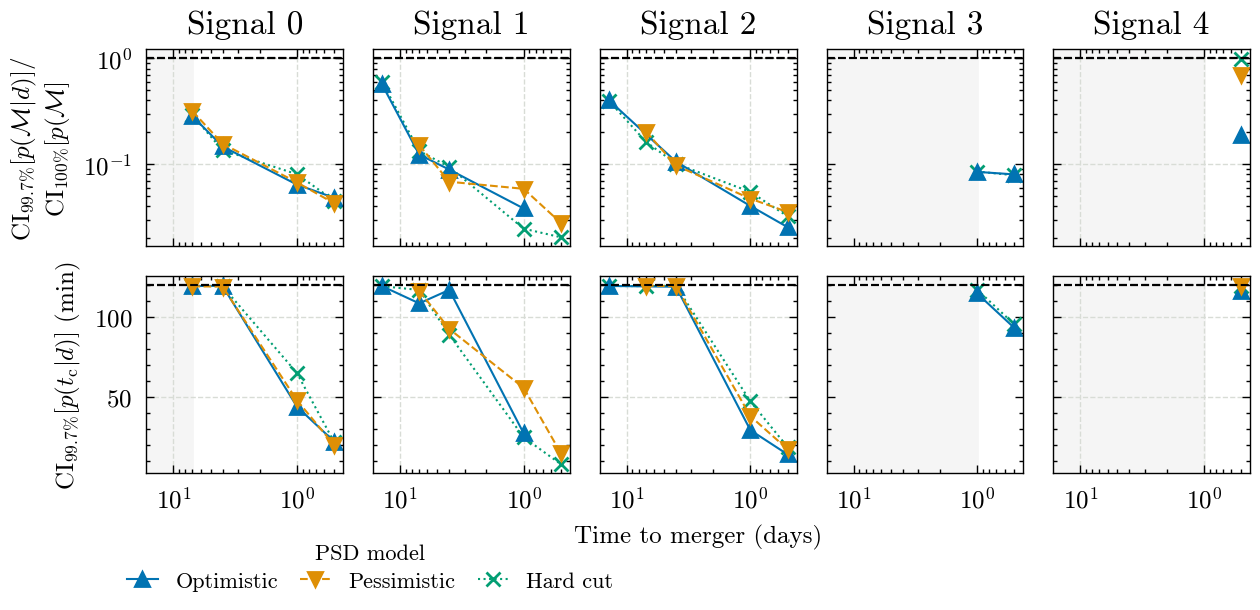

In [7]:
parameters = ["mchirp", "tc"]


scaling = {
    "mchirp": 1 / np.ptp(list(mchirp_priors.values()), axis=1),
    "tc": 1 / 60 * np.ones(5),
}
q = [0.15, 99.85]

hlines = {
    "mchirp": 1,
    "tc": 120,
}

figsize = plt.rcParams["figure.figsize"].copy()
figsize[0] = 2 * figsize[0]
figsize[1] = 1.5 * figsize[1]

fig, axs = plt.subplots(2, 5, sharex=True, sharey="row", figsize=figsize)
for row_id, parameter in enumerate(parameters):
    for inj, inj_samples in posterior_samples.items():
        for psd, psd_samples in inj_samples.items():
            times = get_times_array(psd_samples.keys())
            quantiles = {}
            for time, samples in psd_samples.items():
                quantiles[time] = np.percentile(samples[parameter], q)
            values = scaling[parameter][inj] * np.ptp(np.array(list(quantiles.values())), axis=1)
            axs[row_id, inj].plot(times, values, label=psd, marker=psd_markers.get(psd), ls=psd_ls[psd], color=psd_colours[psd])
            axs[row_id, inj].grid()
            axs[row_id, inj].axhline(hlines[parameter], color="k", ls="--")
axs[-1, 0].invert_xaxis()
axs[-1, 0].set_xscale("log")

axs[0, 0].set_yscale("log")

axs[0, 0].set_ylabel("$\\text{CI}_{99.7\%}[p(\\mathcal{M}|d)] /$\n$ \\text{CI}_{100\%}[p(\\mathcal{M}]$")
axs[1, 0].set_ylabel("$\\text{CI}_{99.7\%}[p(t_{\\text{c}}|d)]$ (min)")

axs[-1, 2].set_xlabel("Time to merger (days)")

for ax in [axs[0, 3], axs[0, 4], axs[1, 3], axs[1, 4]]:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.fill_between([1, xlims[0]], *ylims, color="whitesmoke", zorder=0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

for ax in [axs[0, 0], axs[1, 0]]:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.fill_between([7, xlims[0]], *ylims, color="whitesmoke", zorder=0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

legend_handles = [
    Line2D([0], [1], label=psd_labels[psd], ls=psd_ls[psd], marker=psd_markers[psd], c=psd_colours[psd])
    for psd in psds
]
fig.legend(
    handles=legend_handles,
    title="PSD model",
    loc="center",
    bbox_to_anchor=(0.3, 0.02),
    ncol=3
)

for i in range(5):
    axs[0, i].set_title(f"Signal {i}")

plt.tight_layout()

plt.show()

## Figure 9

In [8]:
tc_priors = {}
for i in range(5):
    tc_priors[i] = get_priors(f"Config_Files/injections/cut_psd/injection{i}.ini", "tc")[0]

In [9]:
priors = {
    "tc": tc_priors,
    "mchirp": mchirp_priors,
}

In [13]:
figsize = plt.rcParams["figure.figsize"].copy()
figsize[0] = 0.9 * figsize[0]
figsize[1] = 2.0 * figsize[1]

fig, axs = plt.subplots(2, 1, figsize=figsize)

psd_to_plot = "optimistic"
inj_id = 0


colours = sns.color_palette("viridis_r", n_colors=5)
truth_color = "C1"
truth_ls = "--"

factor = 1

parameter = "mchirp"
truth = injection_parameters[str(inj_id)][parameter]
ax = axs[0]
inj_samples = posterior_samples[inj_id]
for psd, psd_samples in inj_samples.items():
    if psd != psd_to_plot:
        continue
    for time, samples in psd_samples.items():
        kde = stats.gaussian_kde((samples[parameter]- truth) * factor)
        xx = np.linspace(*priors[parameter][inj_id] - truth, 500) * factor
        ax.plot(xx, kde(xx), color=colours[int(time.split(" ")[-1]) - 1], label=f"{times_lookup[time]} days")
        ax.axvline(0, color=truth_color, ls=truth_ls)
            # axs[inj].hist(samples["tc"], color=colours[int(time.split(" ")[-1]) - 1], **hist_kwargs)
ax.set_xlim(*((priors[parameter][inj_id] - truth) * factor))
time_legend = ax.legend(title="Time to merger", loc="upper left")

ax.set_xlabel(r"$\mathcal{M} - \mathcal{M}_\text{Inj.}\;(\text{M}_{\odot})$")
ax.yaxis.set_ticklabels([])
ax.grid()

parameter = "tc"
factor = 1 / 60
truth = injection_parameters[str(inj_id)][parameter]
ax = axs[1]
inj_samples = posterior_samples[inj_id]
for psd, psd_samples in inj_samples.items():
    if psd != psd_to_plot:
        continue
    for time, samples in psd_samples.items():
        kde = stats.gaussian_kde((samples[parameter] - truth) * factor)
        xx = np.linspace(*priors[parameter][inj_id] - truth, 500) * factor
        ax.plot(xx, kde(xx), color=colours[int(time.split(" ")[-1]) - 1], label=f"{times_lookup[time]} days")
        ax.axvline(0.0, color=truth_color, ls=truth_ls)
            # axs[inj].hist(samples["tc"], color=colours[int(time.split(" ")[-1]) - 1], **hist_kwargs)
ax.set_xlim(*((priors[parameter][inj_id] - truth) * factor))

ax.set_xlabel(r"$t_c\ - t_{c,\text{Inj.}}\;(\text{min})$")
ax.yaxis.set_ticklabels([])
ax.grid()
plt.tight_layout()
plt.show()

ValueError: 
\mathcal{M} - \mathcal{M}_\Text{Inj.}\;(\text{M}_{\odot})
                          ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\'  (at char 26), (line:1, col:27)

Error in callback <function _draw_all_if_interactive at 0x7efd5bf475b0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\mathcal{M} - \mathcal{M}_\Text{Inj.}\;(\text{M}_{\odot})
                          ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\'  (at char 26), (line:1, col:27)

ValueError: 
\mathcal{M} - \mathcal{M}_\Text{Inj.}\;(\text{M}_{\odot})
                          ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\'  (at char 26), (line:1, col:27)

<Figure size 585x800 with 2 Axes>